# Example: Simulating Images with Unstacked Mirror Segments

For the earliest steps of JWST OTE commissioning (OTE-01 through OTE-05), the mirror segments will be scattered across the JWST FOV. It is not until OTE-06 that the segments are moved into the small array that fits on a single NIRCam detector.

### How to Simulate Unstacked Mirror Segment Images
In this notebook, we demonstrate how to simulate images from those early commissioning steps with MIRaGe. The process is as follows:
- Randomly perturb the primary and secondary mirrors to reflect expectations for initial deployment
- Record the tilt of each PM and remove the piston/tip/tilt
- Generate PSF libraries from the perturbed mirror state with piston/tip/tilt removed for each mirror segment
- Generate MIRaGe YAML input files that include:
    - A flag, `expand_catalog_for_segments`, that tells MIRaGe to expect 18 separate segment PSF libraries
    - The directory where to find the special segment PSF libraries
- Generate seed images from those YAMLs that:
    - Iterates over all the point sources in the detector FOV
    - Iterates over the 18 segment PSFs and calculates that segment's location by adding its tilt offset to the original point source location
    - If an offset point source falls within the detector FOV, places the corresponding segment PSF on the image
- Follow the nominal procedures for adding dark exposure and detector effects

### Table of Contents:
1. [Export program information from APT](#export_apt)
2. [Generate the perturbed OTE state](#generate_ote)
3. [Create PSF library files](#make_psf_libs)
4. [Create `.yaml` files for each exposure](#make_yamls)
5. [Generate the simulated image](#simulate_images)

Appendix 1: [Generating data for an entire observation](#simulate_whole_obs)

Appendix 2: [Combining data into a mosaic](#mosaic)

---
## Import necessary packages and modules

In [187]:
# Standard Library Imports
from glob import glob
import multiprocessing
import os
import re
import sys
import time
import yaml

# Third Party Imports
from astropy.io import ascii as asc
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pprint
import pysiaf
import webbpsf

# Local Imports
from mirage import imaging_simulator
from mirage.apt import apt_inputs
from mirage.catalogs import get_catalog
from mirage.dark import dark_prep
from mirage.psf import psf_selection, deployments, segment_psfs
from mirage.ramp_generator import obs_generator
from mirage.seed_image import catalog_seed_image
from mirage.yaml import yaml_generator
# from mirage.yaml import write_observationlist

# View matplotlib plots inline
%matplotlib inline

---
<a id='export_apt'></a>
# 1. Export APT files

Export the `.pointing` and `.xml` files for your given proposal in APT by selecting `File > Export...` and selecting both the xml and pointing file options. Save them in a place you will remember, naming them something descriptive such as `OTE06_1140.pointing`.

The following APT programs will take place when the mirror segments have not been aligned in an image array:
- 1134 (OTE-01: Initial Image Mosaic)
- 1135 (OTE-02: Alignment Matrix 1)
- 1136 (OTE-03: Secondary Mirror Focus Sweep)
- 1137 (OTE-04: Segment ID)
- 1138 (OTE-05: Alignment Matrix 2)

For this example, we are using APT output from a miniaturized version of program 1134 - OTE-01: Initial Image Mosaic. The neccessary files, `OTE01-1134-reduced_mosaic.pointing` and `OTE01-1134-reduced_mosaic.pointing`, are located within the `examples/unstacked_mirror_data/` directory.

In [202]:
prop_id = 1134

# Where the pointing and XML file for this particular OTE CAR are located
input_dir = './unstacked_mirror_data/'

# Change the root if you named your files differently.
root = 'OTE01-{}-reduced_mosaic'.format(prop_id)
pointing_file = os.path.join(input_dir, '{}.pointing'.format(root))
xml_file = os.path.join(input_dir, '{}.xml'.format(root))

### Define location of output files

The process of generating simulated images with MIRaGe produces a lot of files:
- YAMLs carrying the OTE mirror state
- FITS files of the segment PSF images
- YAMLs carrying the specifications for simulations
- FITS files of the simulated seed, dark, and compiled images

We'll save those also in a local directory here:

In [177]:
# Where to save MIRaGe output
out_dir = './unstacked_mirror_data_output/'

# Where the segment PSF library files will be saved to (and read from!)
library_dir = './unstacked_mirror_data_output/gridded_psf_library/'

# Make sure both these directories exist
for full_path in [out_dir, library_dir]:
    if not os.path.exists(full_path):
        os.makedirs(full_path)

---
<a id='generate_ote'></a>
# 2. Generate the perturbed OTE state

We outline two methods here to perturb the primary and secondary mirrors, in order to reflect expectations for initial deployment:
- If you already have a YAML file describing a perturbed OTE state that you want to use to generate segment PSFs, use [option 1](#load_ote_from_yaml). (We provide an example file: `unstacked_mirror_data/deployment_errors_reduced_20190521_173912.yaml`)
- Otherwise, if you need to randomly generate a new perturbed OTE state to generate segment PSFs, use [option 2](#random_ote_state).

<a id='load_ote_from_yaml'></a>
### Option 1: Load OTE state from YAML file

To load an OTE state from an existing YAML file, use `mirage.psf.deployments.load_ote_from_deployment_yaml()`.

This function:
- Loads the OTE state definitions from the YAMLfile (piston, tilt, decenter, ROC, and clocking for all 18 primary mirrors and the secondary mirror)
- Applies them to an adjustable `webbpsf.opds.OTE_Linear_Model_WSS` object
- Records the tilt of each segment in a `numpy` array for future reference
- Removes the piston, tip, and tilt so that each individual segment PSF will be be modeled at the center of a detector

In [178]:
# Load example deployments file
deployments_file = os.path.join(input_dir, 'deployment_errors_reduced_20190521_173912.yaml')
ote, segment_tilts, ote_opd_with_tilts = deployments.load_ote_from_deployment_yaml(deployments_file, out_dir)

Saved OPD to ./unstacked_mirror_data_output/OPD_withtilt_20190523_121137.fits
Saved OPD with piston/tip/tilt removed to ./unstacked_mirror_data_output/OPD_notilt_20190523_121138.fits


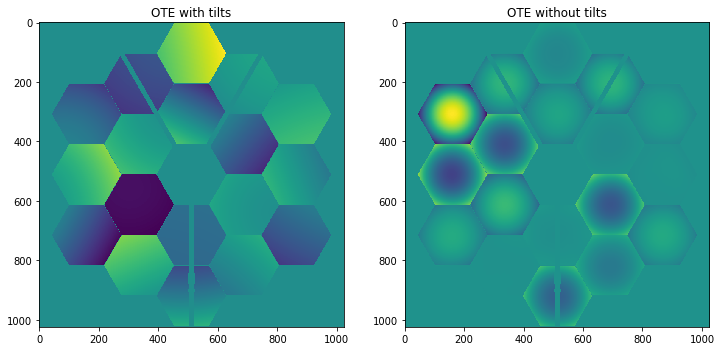

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000    44.2093   -24.6395     0.7176
A2	     0.0000     0.0000     0.0000   -52.6047    39.1492     9.7022
A3	     0.0000     0.0000     0.0000   -41.2598   -13.6447     1.1682
A4	     0.0000     0.0000     0.0000    14.2710    -8.7902    -2.8505
A5	     0.0000     0.0000     0.0000     8.8500   -23.1639    10.2105
A6	     0.0000     0.0000     0.0000     5.2417    23.2414    -6.6126
B1	     0.0000     0.0000     0.0000   -10.0950   -26.2661     8.1064
C1	     0.0000     0.0000     0.0000    14.4809   -11.2717     3.8914
B2	     0.0000     0.0000     0.0000    69.5991   -17.4785    -3.6428
C2	     0.0000     0.0000     0.0000    47.0808   -20.7701    -0.0953
B3	     0.0000     0.0000     0.0000    23.8047    47.6377    -1.6303
C3	     0.0000     0.0000     0.0000    -2.4640   -1

In [179]:
# Display OTE state and tip/tilt vectors
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(ote_opd_with_tilts)
ax1.set_title('OTE with tilts')
ax2.imshow(ote.opd)
ax2.set_title('OTE without tilts')
plt.show()

ote.print_state()

print()
header_string = 'Segment Number |{:^11}|{:^11}'.format('X Tilt', 'Y Tilt')
print(header_string)
print('-' * len(header_string))
for i, (x, y) in enumerate(segment_tilts):
    i_segment = i + 1
    segname = webbpsf.webbpsf_core.segname(i_segment)
    print('{:^14} | {:9.6} | {:9.6}'.format(segname, x, y))

<a id='random_ote_state'></a>
### Option 2: Randomly generate new OTE state

To generate a new, random OTE state, use `mirage.psf.deployments.generate_random_ote_deployment()`.

This function:
- Randomly generates deployment errors for all 18 primary mirrors and the seconday mirror in piston, tilt, decenter, tilt, ROC, and clocking. The magnitude of these errors are pulled from a normal distribution defined by deployment tolerances taken from JWST WFS&C Commissioning and Operations Plan (OTE-24): D36168 / 2299462 Rev C Page 10.
- Applies them to an adjustable `webbpsf.opds.OTE_Linear_Model_WSS` object
- Records the tilt of each segment in a `numpy` array for future reference
- Removes the piston, tip, and tilt so that each individual segment PSF will be be modeled at the center of a detector

We have found, however, that the deployment errors cited in the Ops Plan are rather pessimistic, so for more reasonable OTE states we recommend using the `reduction_factor` argument to reduce the magnitude of the mirror deployments. We use `reduction_factor=0.2` here to reduce the random deployments to 20% of their original values.

In [180]:
ote, segment_tilts, ote_opd_with_tilts = deployments.generate_random_ote_deployment(
    out_dir, reduction_factor=0.2
)

Saved deployment errors to ./unstacked_mirror_data_output/deployment_errors_20190523_122018.yaml
Saved reduced (20.0%) deployment errors to ./unstacked_mirror_data_output/deployment_errors_reduced_20190523_122018.yaml
Saved OPD to ./unstacked_mirror_data_output/OPD_withtilt_20190523_122029.fits
Saved OPD with piston/tip/tilt removed to ./unstacked_mirror_data_output/OPD_notilt_20190523_122029.fits


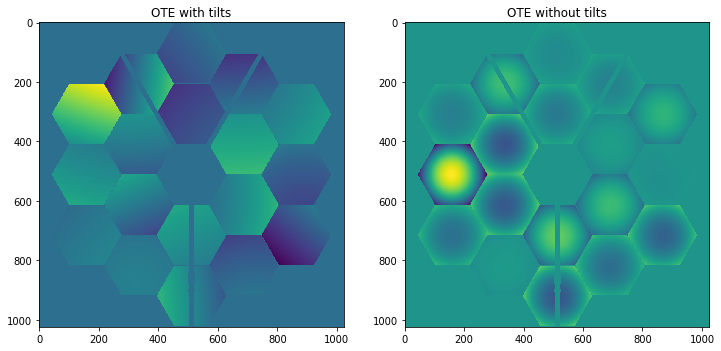

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000   -15.1184    81.3455    -6.9020
A2	     0.0000     0.0000     0.0000   -60.4000   -43.9654    -4.6605
A3	     0.0000     0.0000     0.0000    66.8055   -46.4069    -1.2208
A4	     0.0000     0.0000     0.0000    22.6550    28.8488     3.0799
A5	     0.0000     0.0000     0.0000   -44.8884   -25.2775     7.0744
A6	     0.0000     0.0000     0.0000    72.6767   -38.2303     6.8614
B1	     0.0000     0.0000     0.0000   -26.3868    53.8865     7.2696
C1	     0.0000     0.0000     0.0000   -14.1842   -61.7197     4.3826
B2	     0.0000     0.0000     0.0000   -21.9225   -10.9931     5.9845
C2	     0.0000     0.0000     0.0000    74.8275    25.1914     0.4274
B3	     0.0000     0.0000     0.0000   -36.4566    59.2231    -3.7308
C3	     0.0000     0.0000     0.0000    26.7293     

In [181]:
# Display OTE state and tip/tilt vectors
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(ote_with_tilts_opd)
ax1.set_title('OTE with tilts')
ax2.imshow(ote.opd)
ax2.set_title('OTE without tilts')
plt.show()

ote.print_state()

print()
header_string = 'Segment Number |{:^11}|{:^11}'.format('X Tilt', 'Y Tilt')
print(header_string)
print('-' * len(header_string))
for i, (x, y) in enumerate(segment_tilts):
    i_segment = i + 1
    segname = webbpsf.webbpsf_core.segname(i_segment)
    print('{:^14} | {:9.6} | {:9.6}'.format(segname, x, y))

---
<a id='make_psf_libs'></a>
# 3. Create PSF library files

Once you have a perturbed `webbpsf.opds.OTE_Linear_Model_WSS` object, use the `mirage.psf.segment_psfs.generate_segment_psfs()` function to generate 18 (or more*) segment PSF FITS files.

*You can specify multiple detectors and filters with one function call, but each detector/filter combination which will be saved in a separate file.

In [198]:
segment_psfs.generate_segment_psfs(ote, segment_tilts, library_dir, 
                                  filters='F212N', detectors='NRCA3', overwrite=True)

GENERATING SEGMENT A1-1 DATA
------------------------------

Running instrument: NIRCam, filter: F212N
  Running detector: NRCA3
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_mirror_data_output/gridded_psf_library/nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg01.fits

Elapsed time: 17.051610708236694 

GENERATING SEGMENT A2-2 DATA
------------------------------

Running instrument: NIRCam, filter: F212N
  Running detector: NRCA3
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_mirror_data_output/gridded_psf_library/nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg02.fits

Elapsed time: 17.142733097076416 

GENERATING SEGMENT A3-3 DATA
------------------------------

Running instrument: NIRCam, filter: F212N
  Running detector: NRCA3
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_mirror_data_output/gridded_psf_library/nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg03.fits

Elapsed time: 16.6065390110015

---
<a id='make_yamls'></a>
# 4. Create YAML files for each exposure

Next, we need to make the YAML files that include all of the parameters for MIRaGe to run.

### Get the source catalogs
Parse the `.pointing` file to build catalogs of the sources that will be present in this observation.

In [203]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

cat_dict = {'nircam': {'lw': catalog_filenames_lw,
                       'sw': catalog_filenames_sw}}

Target coordinates:  146.87731 63.24781
Shortwave catalog file 2MASS_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.
Longwave catalog file WISE_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.


### Generate the `.yaml` files
Use `mirage.yaml.yaml_generator` to make all of the YAML files for the given APT program - one file per exposure.

**Some additional settings are required to ensure `yaml_generator` works for unstacked mirror simulations.** You must specify the following attributes before running `create_inputs()` to make the YAMLs, and thus simulations, correctly:
- `yam.psf_paths = os.path.expandvars(library_dir)` - tells MIRaGe to look in `library_dir` to find the FITS files for every exposure
- `yam.expand_catalog_for_segments = True` - tells MIRaGe to look for 18 *segment* PSF files rather than one PSF file
- `yam.add_psf_wings = False` - tells MIRaGe not to add wings to the PSF (we don't care since our PSFs are so big and sloppy anyway)

In [204]:
# Create a series of data simulator input yaml files from APT files
yaml_dir = os.path.join(ote_dir, 'yamls')
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=cat_dict,
                              verbose=True, output_dir=yaml_dir, simdata_output_dir=ote_dir)

# Define the paths to the PSF libraries, and specify to use segment PSFs
yam.psf_paths = os.path.expandvars(library_root_dir)
yam.expand_catalog_for_segments = True
yam.add_psf_wings = False

# Create yaml files
# (Within this, create the observation table.)
yam.create_inputs()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `Central` uses template `NircamImaging`
APTObservationParams Dictionary holds 0 entries before reading template
Primary dither element PrimaryDithers not found, use default primary dithers value (1).
Number of dithers: 1 primary * 1 subpixel = 1
Dictionary read from template has 1 entries.
Found 6 tile(s) for observation 001 Central
Found 2 visits with numbers: [1, 2]
APTObservationParams Dictionary holds 6 entries after reading template (+6 entries)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `002` labelled `W` uses template `NircamImaging`
APTObservationParams Dictionary holds 6 entries before reading template
Primary dither element PrimaryDithers not found, use default primary dithers value (1).
Number of dithers: 1 primary * 1 subpixel = 1
Dictionary read from template has 1 entries.
Foun

## Just for fun: let's examine where the sources will fall in an example exposure

### Examine target pointings relative to apertures and V2/V3 references

Looking at the `.pointing` file, let's plot where the target will appear relative to the NIRCam apertures for each unique pointing.

Example files for each pointing:
--------------------------------
1. jw01134001001_01104_00001_nrca2.yaml
2. jw01134001001_01101_00001_nrcb2.yaml
4. jw01134001002_01105_00001_nrca3.yaml
5. jw01134001002_01106_00001_nrcb5.yaml
6. jw01134001001_01103_00001_nrca2.yaml
25. jw01134001001_01102_00001_nrca3.yaml


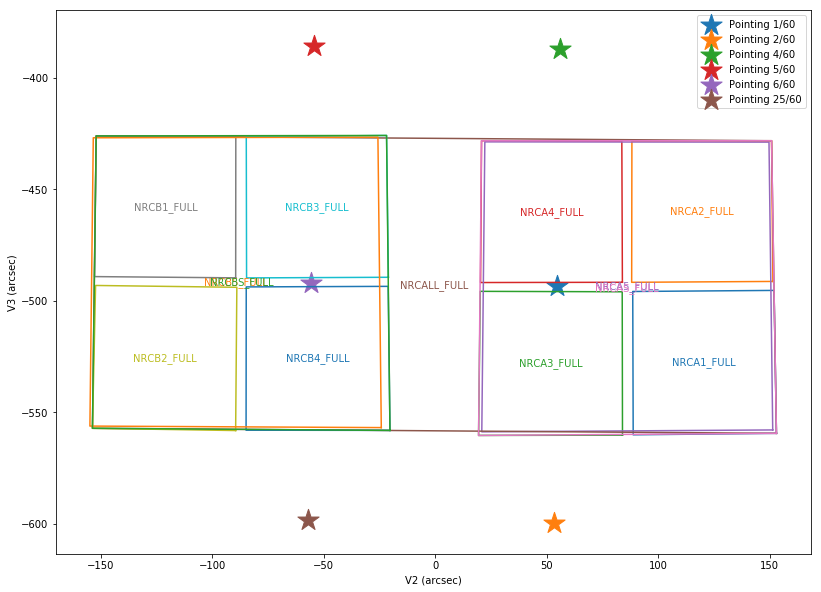

In [83]:
nc_siaf = pysiaf.Siaf('NIRCam')
nc_full = nc_siaf['NRCA3_FULL']

plt.figure(figsize=(15,10))
for apername in sorted(nc_siaf.apernames):
    a = apername
    if ('_FULL' in a) and ('OSS' not in a) and ('MASK' not in a) and (a[-1] != 'P'):
        nc_siaf[a].plot(frame='tel', name_label=a, fill_color='white')
plt.gca().invert_xaxis()

# Compare V2/V3 of targets (from .pointing file)
all_pointings = set([(v2, v3, filename) for v2, v3, filename in zip(yam.info['v2'], 
                                                                yam.info['v3'], 
                                                                yam.info['yamlfile']) if 'jw01134001' in filename])

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, filename) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, filename))

plt.legend()

plt.show()

### Select the YAML to generate an image from

Looking at the pointing figure above, choose one YAML file that we will create a seed image with MIRaGe for. (Be sure to choose a YAML that has a detector and filter that matches the library files you have created so far.)

In [210]:
# Select one YAML to estimate where the sources will be
test_yaml_filename = 'jw01134001002_01106_00001_nrca3.yaml'
test_yaml = os.path.join(yaml_dir, test_yaml_filename)
print(test_yaml)
yaml_ind = np.where(np.array(yam.info['yamlfile']) == test_yaml_filename)[0][0]

./unstacked_mirror_data_output/yamls/jw01134001002_01106_00001_nrca3.yaml


### Calculate and plot V2/V3 locations of NRCA3 aperture, target, and sources

This is the really fun part: knowing the locations of the source in the selected YAML file and the tilt offsets of each mirror segment PSF, we can plot where MIRaGe will put each segment PSF relative to the selected aperture (here, NRCA3).

In [211]:
# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = pysiaf.Siaf('NIRCam')
nc_a3 = nc_siaf['NRCA3_FULL']
nc_all = nc_siaf['NRCALL_FULL']

# Get the target RA/Dec
target_ra = float(yam.info['ra'][yaml_ind])
target_dec = float(yam.info['dec'][yaml_ind])
print('Target RA/Dec:', target_ra, target_dec)

# Get the aperture pointing - THIS IS FOR NRCALL_FULL
pointing_v2 = yam.info['v2'][yaml_ind]
pointing_v3 = yam.info['v3'][yaml_ind]

# Get the aperture RA/Dec - THIS IS FOR NRCA3_FULL
pointing_ra = float(yam.info['ra_ref'][yaml_ind])
pointing_dec = float(yam.info['dec_ref'][yaml_ind])
print('NRCA3 Pointing RA/Dec:', pointing_ra, pointing_dec)

# Generate the attitude matrix to convert RA/Dec to V2/V3
position_angle = float(yam.info['PAV3'][yaml_ind])
attitude_ref = pysiaf.utils.rotations.attitude(
    pointing_v2, pointing_v3, target_ra, target_dec, position_angle
)

# Get the V2/V3 positions of all sources
sw_catalog_file = yam.info['sw_ptsrc'][yaml_ind]
sw_catalog = asc.read(sw_catalog_file)
v2, v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, sw_catalog['x_or_RA'], sw_catalog['y_or_Dec'])

# Get the V2/V3 position of the target (the same as the NRCALL pointing)
target_v2, target_v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, target_ra, target_dec)

# Get the V2/V3 position of the aperture pointing
a3_v2, a3_v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, pointing_ra, pointing_dec)

# Get library to get offsets for each segment
library_list = segment_psfs.get_segment_library_list('NIRCam', 'NRCA3', 'F212N', library_dir)

Target RA/Dec: 146.87731 63.24781
NRCA3 Pointing RA/Dec: 146.77196760996176 63.23422083399082


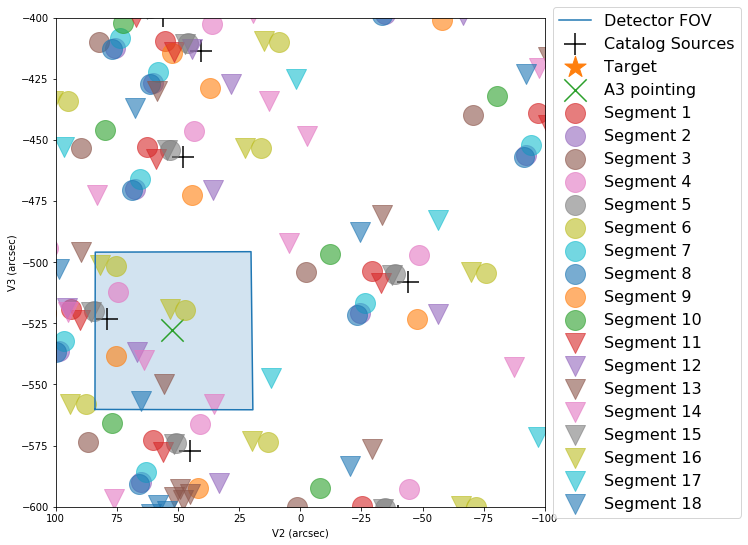

In [228]:
# Plot V2/V3 locations of aperture, target, and sources

fig, ax = plt.subplots(1, 1, figsize=(15,10))
nc_a3.plot(frame='tel', fill_color=None, label='Detector FOV', fill_alpha=0.2)

# Plot catalog sources
plt.scatter(v2, v3, label='Catalog Sources', marker='+', s=500, c='black')

# Plot the target (the same as the NRCALL pointing)
plt.scatter(target_v2, target_v3, label='Target', marker='*', s=500)

# Plot the center of aperture pointing
plt.scatter(a3_v2, a3_v3, label='A3 pointing', marker='x', s=500)

# Plot segment sources
for i_segment in np.arange(1, 19):
    marker = 'o'
    if i_segment > 10:
        marker = 'v'
    x_arcsec, y_arcsec = segment_psfs.get_segment_offset(i_segment, 'NRCA3', library_list)
    plt.scatter(v2 - x_arcsec, v3 + y_arcsec, 
                label='Segment {}'.format(i_segment), marker=marker, s=400, alpha=0.6)

# Just show the area close to the detector
plt.xlim(100, -100)
plt.ylim(-600, -400)

# Shrink current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 0.9, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=16, facecolor=None)

plt.show()

---
<a id='simulate_images'></a>
# 5. Simulate image with MIRaGe

Finally, we can run MIRaGe to generate a seed image simulation of our unstacked mirror state during OTE-01.

From here on out, from the user perspective, the simulation process is identical for nominal imaging cases (see the [imaging example notebook](#Imaging_simulator_use_examples.ipynb). The specifications made in the YAML files are what enable the specialized behavior needed to simulate unstacked mirror simulations with MIRaGe.

In [220]:
print(test_yaml)

'./unstacked_mirror_data_output/yamls/jw01134001002_01106_00001_nrca3.yaml'

In [230]:
img_sim = imaging_simulator.ImgSim()
img_sim.paramfile = test_yaml
img_sim.create()

Requested readout pattern BRIGHT1 is valid. Using the nframe = 1 and nskip = 1
No galaxy catalog provided in yaml file.
NOTE: Using pre-delivery SIAF data for NIRCam
SIAF: Requested NRCA3_FULL   got NRCA3_FULL
Calculating background rate using jwst_background based on low level
Using /Users/lchambers/TEL/mirage/mirage_repo/mirage/config/F212N_nircam_plus_ote_throughput_moda_sorted.txt filter throughput file for background calculation.
Background level set to: 4.696657982663226e-05
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
output dimensions are: [2048 2048]
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Frametime is 10.736770000000002
Segment PSFs will be generated using:
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg01.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg02.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg03.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg04.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg05.fits
nircam_nrca3_f212n_fovp1024_samp1_npsf1_seg06.fits
nircam_nrca3_f212n_fovp1024

    Position angle =  111.0
Filtering point sources to keep only those on the detector
Number of point sources found within the requested aperture: 1
2019-05-23 16:56:58.684696: Working on source 0

Calculating point source lists for segment 12
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (12.078284632761273, -13.392508208395911)
    Position angle =  111.0
Filtering point sources to keep only those on the detector
Number of point sources found within the requested aperture: 2
2019-05-23 16:57:00.071761: Working on source 0
2019-05-23 16:57:00.333355: Working on source 1

Calculating point source lists for segment 13
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (-10.639009612079999, 27.199270586160004)
    Position angle =  111.0
Filtering point sources to keep only those on the detector
Number of point sources found within the requeste

WCS info for /Users/lchambers/TEL/mirage/mirage_repo/examples/unstacked_mirror_data_output/jw01134001002_01106_00001_nrca3_linear.fits complete.


Final linearized exposure saved to:
/Users/lchambers/TEL/mirage/mirage_repo/examples/unstacked_mirror_data_output/jw01134001002_01106_00001_nrca3_linear.fits
Observation generation complete.


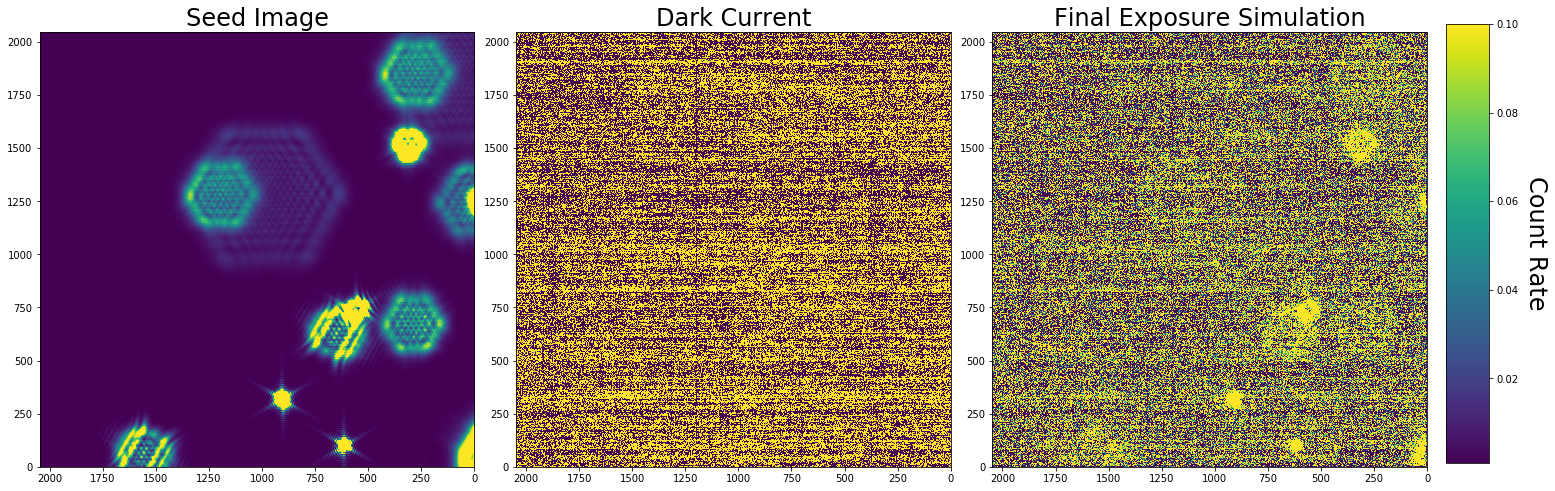

In [251]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 7))
plt.tight_layout()

fitsplot = ax1.imshow(img_sim.seedimage, clim=(0.001, 0.1))
ax1.set_title('Seed Image', size=24)
ax1.invert_xaxis()
ax1.invert_yaxis()

ax2.imshow(img_sim.linDark.data[0,-1,:,:] - img_sim.linDark.data[0,0,:,:], clim=(0.001, 0.1))
ax2.set_title('Dark Current', size=24)
ax2.invert_xaxis()
ax2.invert_yaxis()

linear_output = './unstacked_mirror_data_output/jw01134001002_01106_00001_nrca3_linear.fits'
with fits.open(linear_output) as h:
    lindata = h[1].data
    header = h[0].header
exptime = header['EFFINTTM']
diffdata = (lindata[0,-1,:,:] - lindata[0,0,:,:]) / exptime

ax3.imshow(diffdata, clim=(0.001, 0.1))
ax3.set_title('Final Exposure Simulation', size=24)
ax3.invert_xaxis()
ax3.invert_yaxis()

# Define the colorbar
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = plt.colorbar(fitsplot, cbar_ax)
cbar.set_label('Count Rate', rotation=270, labelpad=30, size=24)

---
<a id='simulate_whole_obs'></a>
# Appendix 1: Simulating many exposures at once

Chances are, you don't want to simulate just one exposure from one detector. In order to simulate all of the exposures from a given observation, write a for loop to iterate over all the YAMLs. We include an example for program 1134 observation 1 below.

### 1. Create all PSF library files
First, make sure that you have created library files for all of the filters and detectors that will be simulated in your observation (for program 1134 observation 1 this means all detectors and filters F212N and F480M):
```python
from mirage.psfs import segment_psfs

segment_psfs.generate_segment_psfs(ote, segment_tilts, library_dir, 
                                   filters=['F212N', 'F480M'], detectors='all')
```

### 2. Run `imaging_simulator` for all YAMLs
Second, grab all of the YAMLs for that specific observation and run the whole image simulator on them all.
```python
from mirage import imaging_simulator

# Get all the 1134 Obs 1 NRCA3 yamls
all_yaml_files = glob(ote_dir + 'jw01134001*.yaml')
n_yamls = len(all_yaml_files)
print('{} FITS files will be generated.'.format(n_yamls))

for yaml in all_yaml_files:
    print('*** SIMULATING YAML {}/{}: {} ***'.format(i+1, n_yamls, yaml))
    img_sim = imaging_simulator.ImgSim()
    img_sim.paramfile = yaml
    img_sim.create()
```

(If you are impatient and ambitious, you can use Python's `multiprocessing` module to the simulation go faster. Even better on a server with more processors! See the [Non-nominal PSF example notebook](#Nonnominal_PSF_simulations_use_examples.ipynb) for a working example of that.)

---
<a id='mosaic'></a>
# Appendix 2: Combine into a mosaic

### Turn linear FITS products into slope images
```python
obs1_fits = glob(os.path.join(ote_dir, 'jw*linear.fits'))
print('{} FITS files produced for program APT 1134 Observation 1'.format(len(obs1_fits)))

# Subtract the first from last for each ramp
for f in obs1_fits:
    with fits.open(f) as hdulist:
        data = hdulist[1].data
        hdr = hdulist[1].header
        
    diff = data[0, -1] - data[0, 0]

    hdu = fits.PrimaryHDU(data=diff, header=hdr)

    new_filename = os.path.join(ote_dir, 'slope_fits', os.path.basename(f))
    hdu.writeto(new_filename, overwrite=True)
    
obs1_slope_fits = glob(os.path.join(ote_dir, 'slope_fits', 'jw*linear.fits'))
```


### Make ops file for QUIP
```python
# Set variables for writing QUIP ops file
outdir = os.path.join(out_dir, 'quip')
outfile = 'congrid'
bindim = 2048
opsfile = outdir+'ops_file_'+outfile.strip("/")+str(bindim)+'.xml'

# Write the file
f = open(opsfile,'w')

f.write('<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n')
f.write('<QUIP_OPERATION_FILE xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="WSS Executive" time="16:22:40.093Z" date="2017-06-14Z" version="6.0.1" operational="false" xsi:noNamespaceSchemaLocation="/Users/lajoie/TEL/WSS-6.0.1/Software/schema/quip_operation_file.xsd">\n')
f.write('    <CORRECTION_ID>R2017061401</CORRECTION_ID>\n')
f.write('    <OPERATION_TYPE>THUMBNAIL</OPERATION_TYPE>\n')
f.write('    <IMAGES>\n')

for filename in obs1_slope_fits:
    f.write("       <IMAGE_PATH>{:s}</IMAGE_PATH>\n".format(filename))
    
f.write( '       </IMAGES>\n'    )
f.write( '       <OUTPUT>\n')
f.write( '           <OUTPUT_DIRECTORY>{:s}quip/</OUTPUT_DIRECTORY>\n'.format(outdir))
f.write( '           <LOG_FILE_PATH>{:s}quip/R2017061401_quip_activity_log.xml</LOG_FILE_PATH>\n'.format(outdir))
f.write( '           <OUT_FILE_PATH>{:s}quip/R2017061401_quip_out.xml</OUT_FILE_PATH>\n'.format(outdir))
f.write( '       </OUTPUT>\n')

f.write('</QUIP_OPERATION_FILE>\n')

f.close()

print('Successfully wrote QUIP ops file to', opsfile)
```